In [81]:
from dateutil import parser
from datetime import datetime
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline


with open('turnstiles_full.pickle', 'rb') as file:
    mta = pickle.load(file)
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,00:00:00,REGULAR,7089463,2401758,2019-06-08 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,04:00:00,REGULAR,7089491,2401764,2019-06-08 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,08:00:00,REGULAR,7089511,2401807,2019-06-08 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,12:00:00,REGULAR,7089598,2401889,2019-06-08 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,16:00:00,REGULAR,7089801,2401946,2019-06-08 16:00:00


In [83]:
# Cleaning steps - identical to those in data_cleaning.ipynb

mta[["PREV_TIME", "PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = \
    mta.groupby(["C/A", "UNIT", "SCP", "STATION"])["TIME", "DATE", "ENTRIES", "EXITS"].\
    transform(lambda x: x.shift(1))
mta.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
mta = mta[mta["ENTRIES"] >= mta["PREV_ENTRIES"]]
mta = mta[mta["EXITS"] >= mta["PREV_EXITS"]]

mta['daily_entries'] = mta['ENTRIES'] - mta['PREV_ENTRIES']
mta['daily_exits'] = mta['EXITS'] - mta['PREV_EXITS']
mta = mta[(mta.daily_entries < 20000) & (mta.daily_exits < 20000)]

mta['total_traffic'] = mta['daily_entries'] + mta['daily_exits']
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,PREV_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS,daily_entries,daily_exits,total_traffic
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,08:00:00,REGULAR,7089511,2401807,2019-06-08 08:00:00,04:00:00,06/08/2019,7089491.0,2401764.0,20.0,43.0,63.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,12:00:00,REGULAR,7089598,2401889,2019-06-08 12:00:00,08:00:00,06/08/2019,7089511.0,2401807.0,87.0,82.0,169.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,16:00:00,REGULAR,7089801,2401946,2019-06-08 16:00:00,12:00:00,06/08/2019,7089598.0,2401889.0,203.0,57.0,260.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,20:00:00,REGULAR,7090115,2401978,2019-06-08 20:00:00,16:00:00,06/08/2019,7089801.0,2401946.0,314.0,32.0,346.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/09/2019,00:00:00,REGULAR,7090281,2402005,2019-06-09 00:00:00,20:00:00,06/08/2019,7090115.0,2401978.0,166.0,27.0,193.0


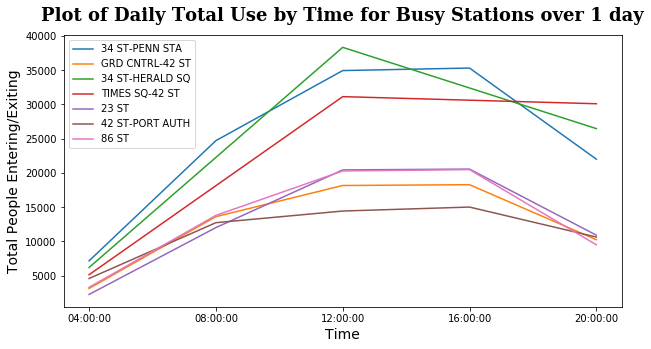

In [127]:
by_station_time = mta.groupby(['STATION', 'PREV_DATE', 'PREV_TIME'], as_index = False).sum()
list_of_stations = ['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', 
                    'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']

plt.figure(figsize=(10,5))
for sta in list_of_stations:
    plt.plot('PREV_TIME', 'total_traffic', 
             data = by_station_time[(by_station_time.STATION == sta) &\
                                    (by_station_time.PREV_DATE == '06/08/2019')].iloc[::2])
plt.legend(list_of_stations)
plt.ylabel('Total People Entering/Exiting', fontsize = 14)
plt.xlabel('Time', fontsize = 14)
plt.title('Plot of Daily Total Use by Time for Busy Stations over 1 day', 
          family = 'Serif', fontsize = 18, weight = 'bold', y = 1.03)

plt.savefig('Traffic_by_Time.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

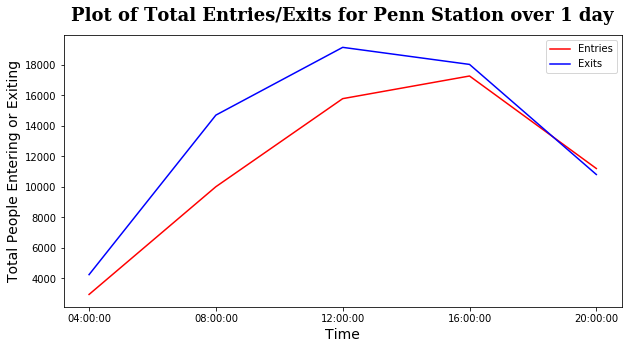

In [125]:
plt.figure(figsize=(10,5))
plt.plot('PREV_TIME', 'daily_entries', color = 'red',
             data = by_station_time[(by_station_time.STATION == '34 ST-PENN STA') &\
                                    (by_station_time.PREV_DATE == '06/08/2019')].iloc[::2])
plt.plot('PREV_TIME', 'daily_exits', color = 'blue',
             data = by_station_time[(by_station_time.STATION == '34 ST-PENN STA') &\
                                    (by_station_time.PREV_DATE == '06/08/2019')].iloc[::2])
plt.legend(['Entries', 'Exits'])
plt.ylabel('Total People Entering or Exiting', fontsize = 14)
plt.xlabel('Time', fontsize = 14)
plt.title('Plot of Total Entries/Exits for Penn Station over 1 day', 
          family = 'Serif', fontsize = 18, weight = 'bold', y = 1.03)

plt.savefig('Penn_Station_Entry_Exit.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

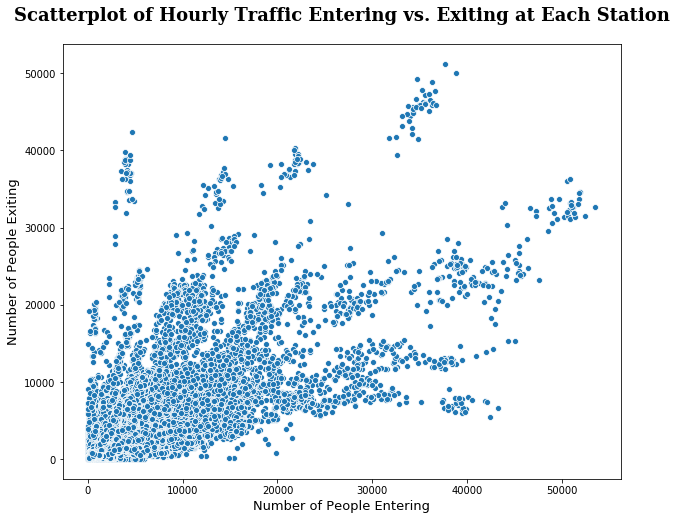

In [124]:
plt.figure(figsize=(10,8))
sns.scatterplot('daily_entries', 'daily_exits', data = by_station_time)
plt.ylabel('Number of People Exiting', fontsize = 13)
plt.xlabel('Number of People Entering', fontsize = 13)
plt.title('Scatterplot of Hourly Traffic Entering vs. Exiting at Each Station', 
          family = 'Serif', fontsize = 18, weight = 'bold', y = 1.04)

plt.savefig('Enter_vs_Exit_Time_Scatter.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()